<a href="https://colab.research.google.com/github/ConstDahoud/simple_dnn/blob/main/03_sine_regression_with_simple_dnn_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sine regression with simple dnn using keras

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 6)

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import matplotlib.pyplot as plt

## Generate the data

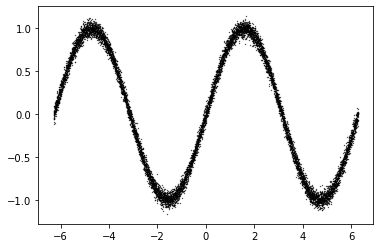

In [2]:
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, np.newaxis]
noise = 0.05 * np.random.normal(size=inputs.shape)
outputs = np.sin(inputs) + noise

plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')


> Define a function for shuffling the data



In [3]:
@tf.function
def column_divide(item):
    return item[0], item[1]


def shuffle_dataset(inputs, outputs, buffer_size=1000, batch_size=32):
    input_tensors = tf.constant(inputs, dtype=tf.float32)
    output_tensors = tf.constant(outputs, dtype=tf.float32)
    dataset = keras.backend.concatenate((input_tensors, output_tensors), axis=1)    # (10000, 2)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)    # 10000 items, the shape of each item: (2, )
    dataset = dataset.shuffle(buffer_size=1000).repeat(2)    # 20000 items
    dataset = dataset.map(column_divide, num_parallel_calls=True)    # 20000 items, the shape of each item: ((input), (output))
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)    # per one item: ([input_1, input_2, ..., input_batch_size], [output_1, output_2, ... , output_batch_size])
    return dataset.prefetch(1)

In [4]:
train_set = shuffle_dataset(inputs, outputs, buffer_size=1000, batch_size=32)
valid_set = shuffle_dataset(inputs, outputs, buffer_size=1000, batch_size=32)

## Define the model

In [5]:
simple_dnn = keras.models.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=[1]),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1)
])

## Compile the model

In [6]:
simple_dnn.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mae', 'mse'])

## Train the model

In [7]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_simple_dnn.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = simple_dnn.fit(train_set, epochs=100,
                         validation_data=valid_set,
                         callbacks=[checkpoint_cb, early_stopping_cb])
simple_dnn = keras.models.load_model("my_simple_dnn.h5")

Epoch 1/100
625/625 [==============================] - 4s 5ms/step - loss: 0.2629 - mae: 0.4147 - mse: 0.2629 - val_loss: 0.2361 - val_mae: 0.4117 - val_mse: 0.2361
Epoch 2/100
625/625 [==============================] - 2s 4ms/step - loss: 0.1424 - mae: 0.3051 - mse: 0.1424 - val_loss: 0.1561 - val_mae: 0.3166 - val_mse: 0.1561
Epoch 3/100
625/625 [==============================] - 2s 4ms/step - loss: 0.1352 - mae: 0.2849 - mse: 0.1352 - val_loss: 0.1583 - val_mae: 0.3035 - val_mse: 0.1583
Epoch 4/100
625/625 [==============================] - 2s 4ms/step - loss: 0.1386 - mae: 0.2751 - mse: 0.1386 - val_loss: 0.1471 - val_mae: 0.2879 - val_mse: 0.1471
Epoch 5/100
625/625 [==============================] - 2s 4ms/step - loss: 0.1343 - mae: 0.2670 - mse: 0.1343 - val_loss: 0.1326 - val_mae: 0.2751 - val_mse: 0.1326
Epoch 6/100
625/625 [==============================] - 3s 4ms/step - loss: 0.1135 - mae: 0.2453 - mse: 0.1135 - val_loss: 0.1232 - val_mae: 0.2842 - val_mse: 0.1232
Epoch 7/10

## Test the model

In [8]:
test_loss, test_mse, test_mae = simple_dnn.evaluate(inputs, outputs, verbose=0)
print('\n테스트 MSE:', test_mse)


테스트 MSE: 0.04256964102387428


## Let visualize the result

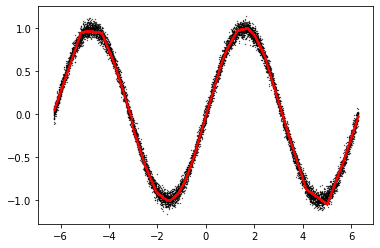

In [9]:
test_output_pred = simple_dnn.predict(inputs)

plt.scatter(inputs[:, 0], outputs[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], test_output_pred[:, 0], c='r', marker='o', s=0.1)